In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.ndimage.filters import uniform_filter1d
from scipy.signal import butter , filtfilt
from scipy.signal import find_peaks
from scipy import signal

import pylab
import os.path
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import KFold

import re


2021-11-30 13:36:08.764961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 13:36:08.764988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#folders = glob.glob(r'./Data/Smartphone3/*')
#print(folders)

In [3]:
# Reading the data and initialising the used arrays for the data and the label

# Shapes of arrays
# Training input:  (750, 40000,4)
# Training label:  (750,)
# Subject label:   (750,)
training_data=np.zeros((750,60000,4))
training_label=np.zeros((750))
training_subject=np.zeros((750))
training_data_len=np.zeros((750))
training_data_freq=np.zeros((750))
k=0

s_id = range(150, 275) 

for i in s_id:
#     print(i)
#     if i == 216:
        for j in range(2):

            path_norm="./Data/Smartphone3/subject"+str(i).zfill(2)+"_normal0"+str(j+1)+"/Accelerometer.csv"
            path_up="./Data/Smartphone3/subject"+str(i).zfill(2)+"_upstairs0"+str(j+1)+"/Accelerometer.csv"
            path_down="./Data/Smartphone3/subject"+str(i).zfill(2)+"_downstairs0"+str(j+1)+"/Accelerometer.csv"

    #         print(path_norm, path_up, path_down)

            if os.path.isfile(path_norm): 

                data_norm=pd.read_csv(path_norm,sep=",", header=None)

                #print(data_norm[0])
                training_data[k,0:(len(data_norm[0])-1),0]=data_norm[0][1:]
                training_data[k,0:(len(data_norm[0])-1),1]=data_norm[1][1:]
                training_data[k,0:(len(data_norm[0])-1),2]=data_norm[2][1:]
                training_data[k,0:(len(data_norm[0])-1),3]=data_norm[3][1:]
                training_data_len[k]=len(data_norm[0])
                training_label[k]=0
                training_subject[k]=i
                # print(training_data[k,:])
                k=k+1



            if os.path.isfile(path_up): 

                data_up=pd.read_csv(path_up,sep=",", header=None)

                #print(data_up[0])
                training_data[k,0:(len(data_up[0])-1),0]=data_up[0][1:]
                training_data[k,0:(len(data_up[0])-1),1]=data_up[1][1:]
                training_data[k,0:(len(data_up[0])-1),2]=data_up[2][1:]
                training_data[k,0:(len(data_up[0])-1),3]=data_up[3][1:]
                training_data_len[k]=len(data_up[0])
                training_label[k]=1
                training_subject[k]=i
                # print(training_data[k,:])
                k=k+1

            if os.path.isfile(path_down): 

                data_down=pd.read_csv(path_down,sep=",", header=None)

                #print(data_down[0])
                training_data[k,0:(len(data_down[0])-1),0]=data_down[0][1:]
                training_data[k,0:(len(data_down[0])-1),1]=data_down[1][1:]
                training_data[k,0:(len(data_down[0])-1),2]=data_down[2][1:]
                training_data[k,0:(len(data_down[0])-1),3]=data_down[3][1:]
                training_data_len[k]=len(data_down[0])
                training_label[k]=2
                training_subject[k]=i
                # print(training_data[k,:])
                k=k+1

number_of_inputs=k

In [4]:
#Get the frequency of the sensors
for i in range(number_of_inputs):
     
    #print(training_data[i,int(training_data_len[i]-1),0])
    training_data_freq[i]=(training_data_len[i]-1)/training_data[i,round(training_data_len[i]-2),0]
    print(training_data_freq[i])

494.4859957746785
480.4252274546392
481.46814768510416
492.99512845783386
482.8138841530943
481.15479742633426
417.34702871775886
100.49758647769949
100.51375889252124
417.29707890264575
100.49869422173079
100.49798615531708
417.3645847143792
417.3134652579085
417.0622277219096
417.3843629705148
417.2114430420916
417.32233087026697
414.54420066857415
413.9212074862057
414.0282052027683
414.5175255785026
414.0267485973384
414.2649598095219
417.41332808131443
417.3058263689219
417.3690297730995
417.38939199103163
417.3012205873854
417.31560646488794
401.644569876145
401.50517598724684
401.22844106064974
401.6677167811282
401.28495580196517
401.3312652861513
401.8190610683706
401.6689497988644
401.65638363056433
401.18809390734907
401.08714080708484
401.7050464309227
401.3322451860511
401.2274923625386
401.73430123689536
401.7455418019782
401.390996890726
401.1484683695994
401.730489159535
400.8623108742948
401.15985809200725
500.0112515477592
500.05570462432627
500.0707754288786
500.0150

In [5]:
# Filter of the data
# This first filter is used on the data


cutFreq = 10
training_data_filtered=np.zeros((750,60000,4))
training_data_filtered[:,:,0]=training_data[:,:,0]
"A single Butterworth filter with a cutoff frequency between 0.1 and 15 Hz is "
"sufficient to reduce a large component of noise from the data and serves "
"as the best preprocessing step"
#     sampling_rate = round(3/(time[2]-time[1]),3)    # sampling rate 416 HZ 
for i in range(number_of_inputs):
    for j in range(1,4):
        sampling_rate=training_data_freq[i]
        if sampling_rate >= 20:
            cutoff_freq = cutFreq/(0.5*sampling_rate)  
            # cutoff_freq = 5
            b,a = butter(2, cutoff_freq, btype = 'low',analog= False)
            data = training_data[i,:int(training_data_len[i]-2),j] #dataset.iloc[:,1:2]
            data = np.transpose(data)
            filtered_data = filtfilt(b,a,data)
            training_data_filtered[i,:int(training_data_len[i]-2),j] = np.transpose(filtered_data)

In [6]:
# This second filter is only used to find the extraction points on the data
# With the low cut of frequency only a sinusoidal oscillation remains

cutFreq = 1
training_data_filtered_2=np.zeros((750,60000,4))
training_data_filtered_2[:,:,0]=training_data[:,:,0]
"A single Butterworth filter with a cutoff frequency between 0.1 and 15 Hz is "
"sufficient to reduce a large component of noise from the data and serves "
"as the best preprocessing step"
#     sampling_rate = round(3/(time[2]-time[1]),3)    # sampling rate 416 HZ 
for i in range(number_of_inputs):
    for j in range(1,4):
        sampling_rate=training_data_freq[i]
        if sampling_rate > 2*cutFreq:
            cuttoff_freq = cutFreq/(0.5*sampling_rate)  
            b,a = butter(2, cuttoff_freq, btype = 'low',analog= False)
            data = training_data[i,:int(training_data_len[i]-1),j] #dataset.iloc[:,1:2]
            data = np.transpose(data)
            filtered_data = filtfilt(b,a,data)
            training_data_filtered_2[i,:int(training_data_len[i]-1),j] = np.transpose(filtered_data)

0.0
150.0
1.0
150.0


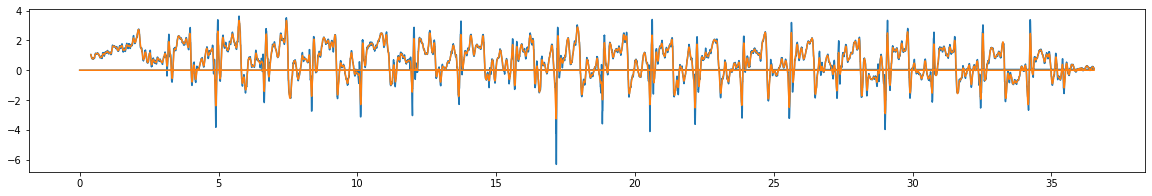

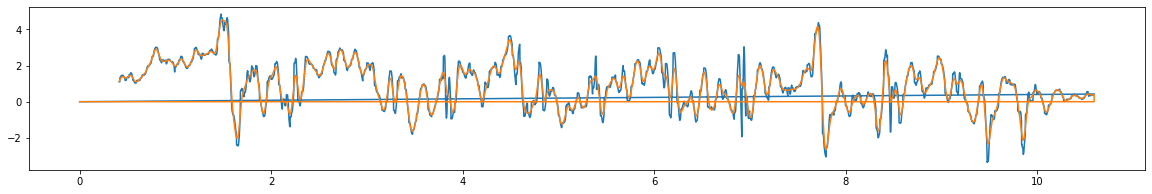

In [7]:
#Plot how the filtered data looks
for i in range(2):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure(i)
    plt.plot(training_data[i,0:int(training_data_len[i]),0],training_data[i,0:int(training_data_len[i]),1])
    plt.plot(training_data_filtered[i,0:int(training_data_len[i]),0],training_data_filtered[i,0:int(training_data_len[i]),1])
    
    print(training_label[i])
    print(training_subject[i])

In [8]:
#Extraction
#The finding of the relevant peaks of the sinusoidal oscillation is easy 
#and the distance between the peaks is used to find the walking sequence

training_data_extracted=np.zeros((number_of_inputs,60000,4))
training_data_len_extracted=np.zeros((number_of_inputs))
peaks_i=np.zeros((number_of_inputs,700))

extract_start=0
extract_end=0
safe_range_factor=7
safe_range_factor_m=safe_range_factor-1
# for i in range(1,30):
for i in range(number_of_inputs):
    
    peak_indices, _ =find_peaks(training_data_filtered_2[i,0:int(training_data_len[i]),1], prominence=0.4)#,distance=150
    peak_distance=np.zeros(len(peak_indices))
    peaks_i[i,:len(peak_indices)]=peak_indices

    if peak_indices.shape[0] > 1:

    # print (type(peak_indices))
    
        for k in range(len(peak_indices)-1):
            peak_distance[k]=peak_indices[k+1]-peak_indices[k]
            
        peak_distance_mean=np.mean(peak_distance[len(peak_distance)//safe_range_factor:safe_range_factor_m*len(peak_distance)//safe_range_factor])
        try:
            extract_start_peak=int(len(peak_distance)//safe_range_factor) - np.where(np.logical_or(np.flip(peak_distance[:len(peak_distance)//safe_range_factor]) > 1.2*peak_distance_mean , np.flip(peak_distance[:len(peak_distance)//safe_range_factor]) < 0.8*peak_distance_mean))[0][0]
            extract_end_peak=int(safe_range_factor_m*len(peak_distance)//safe_range_factor) - 1 + np.where(np.logical_or( peak_distance[safe_range_factor_m*len(peak_distance)//safe_range_factor:len(peak_distance)]  > 1.2*peak_distance_mean, peak_distance[safe_range_factor_m*len(peak_distance)//safe_range_factor:len(peak_distance)]< 0.8*peak_distance_mean))[0][0]
        except:
            extract_start_peak=int(len(peak_distance)//safe_range_factor)
            extract_end_peak=int(safe_range_factor_m*len(peak_distance)//safe_range_factor)
            
        extract_start=peak_indices[extract_start_peak]
        extract_end=peak_indices[extract_end_peak]
        
        
        training_data_len_extracted[i]=extract_end-extract_start
        
        for j in range(0,4):
            training_data_extracted[i,:int(training_data_len_extracted[i]),j]=training_data_filtered[i,extract_start:extract_end,j]

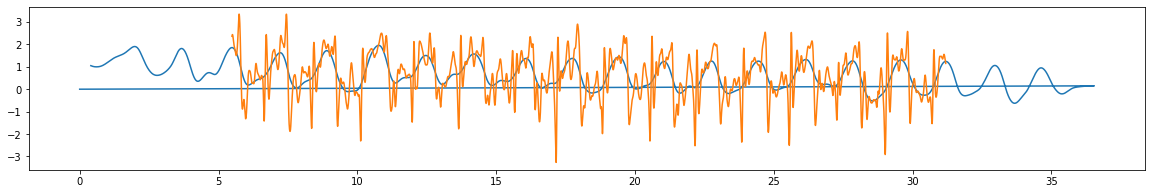

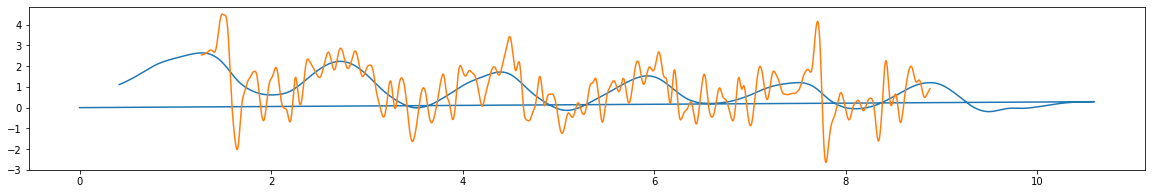

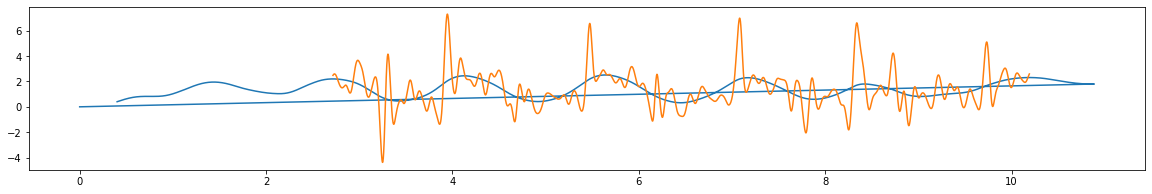

In [9]:
#Plot to show the extracted data

for i in range(3):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure(i)
    plt.plot(training_data_filtered_2[i,0:int(training_data_len[i]),0],training_data_filtered_2[i,0:int(training_data_len[i]),1])
    plt.plot(training_data_extracted[i,0:int(training_data_len_extracted[i]),0],training_data_extracted[i,0:int(training_data_len_extracted[i]),1])


In [10]:
###Rotation 
#The Rotation of the data is based of the gravitational acceleration.
#This gets detected with the mean of the time series for every axis and the axis with the highest absolute value of the 
#mean gets set as the y-axis.
#

training_data_rotated=np.zeros((number_of_inputs,60000,4))

for i in range(number_of_inputs):
    
# for i in range(1):
    training_data_rotated[i,:int(training_data_len_extracted[i]),0]=training_data_extracted[i,:int(training_data_len_extracted[i]),0]
    
    #for j in range(1,4):
    mean_x=np.abs(np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),1]))
    mean_y=np.abs(np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),2]))
    mean_z=np.abs(np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),3]))
    
    mean_y_sign=np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),2])
    
    index=np.argmax([mean_x,mean_y,mean_z])
    if mean_y_sign>0:
        if index==0:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]


        if index==1:
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]


        if index==2:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]
    
    if mean_y_sign<0:

        if index==0:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=-training_data_extracted[i,:int(training_data_len_extracted[i]),1]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]


        if index==1:
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=-training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]


        if index==2:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=-training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]


/home/raj/anaconda3/envs/CIE21/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raj/anaconda3/envs/CIE21/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
#Segmentation
#Again filter with low cut of frequency used to get a clean sinusoidal oscillation to find the relevant peaks easily


cutFreq = 1.8
training_data_filtered_3=np.zeros((number_of_inputs,60000,4))
training_data_filtered_3[:,:,0]=training_data_rotated[:,:,0]
"A single Butterworth filter with a cutoff frequency between 0.1 and 15 Hz is "
"sufficient to reduce a large component of noise from the data and serves "
"as the best preprocessing step"
#     sampling_rate = round(3/(time[2]-time[1]),3)    # sampling rate 416 HZ 
for i in range(number_of_inputs):
    for j in range(1,4):
        sampling_rate=training_data_freq[i]
        if sampling_rate >= 3.6:
            cutoff_freq = cutFreq/(0.5*sampling_rate)  
            b,a = butter(2, cutoff_freq, btype = 'low',analog= False)
            data = training_data_rotated[i,:int(training_data_len_extracted[i]-1),j] #dataset.iloc[:,1:2]
            data = np.transpose(data)
            filtered_data = filtfilt(b,a,data)
            training_data_filtered_3[i,:int(training_data_len_extracted[i]-1),j] = np.transpose(filtered_data)

print(training_data_filtered_3)

[[[ 5.48526502  2.26256755  9.50223195  0.67816976]
  [ 5.48726502  2.26108233  9.50688638  0.66658399]
  [ 5.48926588  2.25956013  9.51161577  0.65489156]
  ...
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 1.27286325  2.77080131  9.55978261  0.08702401]
  [ 1.27486328  2.77597291  9.56574546  0.0830272 ]
  [ 1.27686332  2.78117549  9.5717714   0.07894242]
  ...
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 2.71745632  2.20366749  8.55237947  1.91678652]
  [ 2.71945636  2.20040072  8.54405768  1.91908367]
  [ 2.72145639  2.19711858  8.53570595  1.92146295]
  ...
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 ...

 [[ 7.69987338  2.12799083  9.9240

In [15]:
The walking sequence gets cut into individual steps based on the peaks of the signal

training_data_sampled=np.zeros((number_of_inputs,190,1400,4)) ##number of input, number of samples, sampled data, axis
# training_data_sampled = signal.resample(training_data_rotated,1400) 
peaks_i=np.zeros((number_of_inputs,700))
num_of_peaks=np.zeros((number_of_inputs))
peak_distance_i=np.zeros((number_of_inputs,700))

# for i in range(30,40):
for i in range(number_of_inputs):
     
    peak_indices_1, _ =find_peaks(training_data_filtered_3[i,0:int(training_data_len_extracted[i]),2], prominence=0.5)#2.8 prom 5,distance=150 #,distance=training_data_freq[1]*0.5

    peak_indices=peak_indices_1
    peak_distance=np.zeros(len(peak_indices))
    peaks_i[i,:len(peak_indices)]=peak_indices
    num_of_peaks[i]=len(peak_indices)
    
    for j in range(len(peak_indices)-1):#

        peak_distance[j]=peak_indices[j+1]-peak_indices[j]
        
        peak_distance_i[i,j]=peak_distance[j]
        
        for k in range (4):
            training_data_sampled[i,j,:int(peak_distance[j]),k]=training_data_rotated[i,peak_indices[j]:peak_indices[j+1],k]
# print(training_data_rotated.shape)

(513, 60000, 4)


In [ ]:
#Show Plot of segmented data but with different sample length
sample_length=500
for i in range(1): #(number_of_imputs):
# for i in range(number_of_imputs):

    for j in range(int(num_of_peaks[i])-1):#
        
        if training_label[i]==0:
            plt.figure(1)
            plt.rcParams["figure.figsize"] = (20,3)
            plt.plot(np.linspace(0,sample_length,sample_length),training_data_sampled[i,j,0:sample_length,1])
            plt.figure(2)
            plt.plot(np.linspace(0,sample_length,sample_length),training_data_sampled[i,j,0:sample_length,2])
            plt.figure(3)
            plt.plot(np.linspace(0,sample_length,sample_length),training_data_sampled[i,j,0:sample_length,3])


In [ ]:
# Resample 
#Every step gets resampled to the same number of datapoints
#Two peaks from the segmentation make up one step and the order of the reconstruction gets adressed based on the maximum value. th

resample_length=300
training_data_resampled=np.zeros((number_of_inputs,int(np.max(num_of_peaks)//2-1),resample_length,3))

# for i in range(40):
for i in range(number_of_inputs):
    max_even=0
    max_odd=0
    for j in range((int(num_of_peaks[i]//2)-1)):#
        max_even+=np.max(training_data_sampled[i,2*j,:int(peak_distance_i[i,2*j])//2,2])
        max_odd+=np.max(training_data_sampled[i,2*j+1,:int(peak_distance_i[i,2*j+1])//2,2])
                    
    mean_max_even=max_even
    mean_max_odd=max_odd

    if mean_max_even>mean_max_odd:
        for j in range((int(num_of_peaks[i]//2)-1)):#
            for k in range(3):#
                x1=training_data_sampled[i,2*j,:int(peak_distance_i[i,2*j]),k+1]
                x2=training_data_sampled[i,2*j+1,:int(peak_distance_i[i,2*j+1]),k+1]
                x3=np.concatenate((x1,x2))
                #training_data_resampled[i,j,:,0]=
                training_data_resampled[i,j,:,k]=signal.resample(x3,resample_length)

    else:
        for j in range((int(num_of_peaks[i]//2)-2)):#                                                                                   
            for k in range(3):#
                x1=training_data_sampled[i,2*j+1,:int(peak_distance_i[i,2*j+1]),k+1]
                x2=training_data_sampled[i,2*j+2,:int(peak_distance_i[i,2*j+2]),k+1]
                x3=np.concatenate((x1,x2))
                #training_data_resampled[i,j,:,0]=
                training_data_resampled[i,j,:,k]=signal.resample(x3,resample_length)
            #   print(i)

In [ ]:
#Plot for the resampled data

for i in range(0,6): #(number_of_imputs):
# for i in range(number_of_imputs):

    for j in range(0,int(num_of_peaks[i])//2-1):#
        
        if training_label[i]==0:
#         if (j % 2) == 0:
            plt.rcParams["figure.figsize"] = (20,3)
#             plt.figure(3*i)
#             plt.title(str(i)+" subj: "+str(training_subject[i]))
#             plt.plot(np.linspace(0,resample_length,resample_length),training_data_resampled[i,j,0:resample_length,0])
            
            plt.figure(3*i+1)
            plt.title(str(i)+" subj: "+str(training_subject[i]))
            plt.plot(np.linspace(0,resample_length,resample_length),training_data_resampled[i,j,0:resample_length,1])
#             plt.figure(3*i+2)
#             plt.plot(np.linspace(0,resample_length,resample_length),training_data_resampled[i,j,0:resample_length,2])

In [ ]:
#Cleaning of Data
#The mean of all the data points across all steps were taken and if the mean of the data points 
#differed too much then that step was removed. 

training_data_cleaned=np.zeros((number_of_inputs,int(np.max(num_of_peaks)//2-1),resample_length,3))
# standart_deviation=np.zeros(int(np.max(num_of_peaks)//2-1))
# mean_of_sample_point=np.zeros(resample_length)
deviation_of_mean=np.zeros((int(np.max(num_of_peaks)//2-1),resample_length))
average_deviation=np.zeros(int(np.max(num_of_peaks)//2-1))

# for j in range(0,int(num_of_peaks[i])//2-1):#
# for i in range(330,334): #(number_of_inputs):
for i in range(number_of_inputs): 
    for l in range(resample_length):#
        
            mean_of_sample_point=np.mean(training_data_resampled[i,training_data_resampled[i,:,l,1].nonzero(),l,1]) 
            
            for j in range(0,int(num_of_peaks[i])//2-1):#
                
                deviation_of_mean[j,l]=(training_data_resampled[i,j,l,1]-mean_of_sample_point)**2
       
    for j in range(0,int(num_of_peaks[i])//2-1):#
            
        average_deviation[j]=np.mean(deviation_of_mean[j,deviation_of_mean[j,:].nonzero()])   
        if average_deviation[j]>1.8:
            training_data_cleaned[i,j,:,:]=0
        else:                            
            training_data_cleaned[i,j,:,:]=training_data_resampled[i,j,:,:]                     


In [ ]:
# Plot of cleaned data
for i in range(0,6): #(number_of_imputs):
# for i in range(number_of_imputs):

    for j in range(0,int(num_of_peaks[i])//2-1):#

        if training_label[i]==0:
    #         if (j % 2) == 0:
            plt.rcParams["figure.figsize"] = (20,3)
    #             plt.figure(3*i)
    #             plt.title(str(i)+" subj: "+str(training_subject[i]))
    #             plt.plot(np.linspace(0,resample_length,resample_length),training_data_cleaned[i,j,0:resample_length,0])

            plt.figure(3*i+1)
            plt.title(str(i)+" subj: "+str(training_subject[i]))
            plt.plot(np.linspace(0,resample_length,resample_length),training_data_cleaned[i,j,0:resample_length,1])
    #             plt.figure(3*i+2)
    #             plt.plot(np.linspace(0,resample_length,resample_length),training_data_cleaned[i,j,0:resample_length,2])

In [ ]:
#Construct Training Input Array
#Only the valid data gets taken and assemled into one large array as the input for the model
#One input of the data contains one step and all axis as a flattened array

training_input_zeros=np.zeros((60000,3*resample_length))
training_input_label_zeros=np.zeros((60000))
                        
k=0
for i in range(number_of_inputs):
# for i in range(1):
    for j in range(int(num_of_peaks[i])//2-1):#
        if np.count_nonzero(training_data_cleaned[i,j,:,1])!=0:
#         nonzero_training_data_cleaned=training_data_cleaned[i,j,:,:]
        
            training_input_zeros[k,:300]=training_data_cleaned[i,j,:,0]
            training_input_zeros[k,300:600]=training_data_cleaned[i,j,:,1]
            training_input_zeros[k,600:900]=training_data_cleaned[i,j,:,2]
            training_input_label_zeros[k]=training_label[i]     
                                       
            k+=1   
            
training_input=np.zeros((k,3*resample_length))   
training_input_label=np.zeros((k))

training_input[:,:]=training_input_zeros[:k,:]
training_input_label[:]=training_input_label_zeros[:k]
# print(training_input)
# print(training_input.shape)
# print(training_input_label)
# print(pd.DataFrame(training_input))
# print(training_data_cleaned[:,1,1,:])


In [ ]:
#Plot of the input for the network

plt.figure(1)
                 
# for i in range (training_input.shape[0]):
for i in range (0,25):
#     plt.title(str(i)+" subj: "+str(training_subject[i]))
    plt.plot(np.linspace(0,resample_length*3,resample_length*3),training_input[i,:])
#     plt.plot(np.linspace(0,100,100),training_input[i,:100])

In [ ]:
X = training_input
y = training_input_label

kf = KFold(n_splits=5)
kf.get_n_splits(X)
#print(kf)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X, X_train, y_train)
    print(X_train.shape)
    

    #y_pred = forest.predict(X_test[:])
    #print('Test Accuracy: %.3f' % accuracy_score(y_test, y_pred))

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(900,)), 
        tf.keras.layers.Dense(1000, activation ='relu'),
        tf.keras.layers.Dense(500, activation ='relu'),
        tf.keras.layers.Dense(3, activation ='softmax')
        ])
        
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    # train the neural network for 5 training epochs
    history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), verbose = 1);
        
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1);

    print('Loss=', loss)
    print('accuracy=', accuracy)


In [ ]:
print(X.shape)
print(y)

In [ ]:
def plot_learningCurve(history, epochs):
    #Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()

    #Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()

In [ ]:
plot_learningCurve(history, 50)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict(X_test)
classes_x = np.argmax(y_pred,axis=1)

In [ ]:
mat = confusion_matrix(y_test, classes_x)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize = (10,10))

In [ ]:
t_d = np.zeros((800,60000,4))
print(t_d)